# Baseline: Training Neural Network with Position Labels (Supervised)

In [1]:
import FeatureEngineering
import tensorflow as tf
import espargos_0007
import cluster_utils
import neural_network_utils
import CCEvaluation
import numpy as np
import os

2025-04-11 19:49:53.899466: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-11 19:49:53.920233: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-11 19:49:53.926563: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-11 19:49:53.942428: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-11 19:49:54.850714: W tensorflow/compiler/tf2

In [2]:
# Loading all the datasets can take some time...
training_set_robot = espargos_0007.load_dataset(espargos_0007.TRAINING_SET_ROBOT_FILES)
test_set_robot = espargos_0007.load_dataset(espargos_0007.TEST_SET_ROBOT_FILES)
test_set_human = espargos_0007.load_dataset(espargos_0007.TEST_SET_HUMAN_FILES)

all_datasets = training_set_robot + test_set_robot + test_set_human

  0%|          | 0/3 [00:00<?, ?it/s]

Loading espargos-0007/espargos-0007-meanders-nw-se-1.tfrecords


I0000 00:00:1744400996.237581   71137 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1744400996.291503   71137 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1744400996.291892   71137 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1744400996.295448   71137 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Loading espargos-0007/espargos-0007-meanders-sw-ne-1.tfrecords


2025-04-11 19:50:19.519301: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loading espargos-0007/espargos-0007-randomwalk-1.tfrecords


  0%|          | 0/1 [00:00<?, ?it/s]

Loading espargos-0007/espargos-0007-randomwalk-2.tfrecords


2025-04-11 19:50:34.529481: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


  0%|          | 0/1 [00:00<?, ?it/s]

Loading espargos-0007/espargos-0007-human-helmet-randomwalk-1.tfrecords


In [3]:
for dataset in all_datasets:
    dataset["clutter_acquisitions"] = np.load(os.path.join("clutter_channel_estimates", os.path.basename(dataset["filename"]) + ".npy"))

In [4]:
for dataset in all_datasets:
    cluster_utils.cluster_dataset(dataset)

Clustering dataset espargos-0007/espargos-0007-meanders-nw-se-1.tfrecords


  0%|          | 0/174647 [00:00<?, ?it/s]

Clustering dataset espargos-0007/espargos-0007-meanders-sw-ne-1.tfrecords


  0%|          | 0/204711 [00:00<?, ?it/s]

Clustering dataset espargos-0007/espargos-0007-randomwalk-1.tfrecords


  0%|          | 0/103524 [00:00<?, ?it/s]

Clustering dataset espargos-0007/espargos-0007-randomwalk-2.tfrecords


  0%|          | 0/139427 [00:00<?, ?it/s]

Clustering dataset espargos-0007/espargos-0007-human-helmet-randomwalk-1.tfrecords


  0%|          | 0/33011 [00:00<?, ?it/s]

### Feature Engineering

Pre-compute features for neural network training in NumPy

In [5]:
FeatureEngineering.precompute_features(all_datasets)

Pre-computing training features for 43620 datapoints in total


  0%|          | 0/43620 [00:00<?, ?it/s]

### Neural Network Training

In [6]:
def combine_datasets(datasets):
    all_cluster_features = []
    all_cluster_positions = []

    for dataset in datasets:
        all_cluster_features.append(dataset["cluster_features"])
        all_cluster_positions.append(dataset["cluster_positions"][:,:2])
    
    return np.concatenate(all_cluster_positions), np.concatenate(all_cluster_features)

In [7]:
training_set_robot_groundtruth_positions, training_set_robot_features = combine_datasets(training_set_robot)
test_set_robot_groundtruth_positions, test_set_robot_features = combine_datasets(test_set_robot)
test_set_human_groundtruth_positions, test_set_human_features = combine_datasets(test_set_human)

In [8]:
def to_supervised_dataset(datasets):
    supervised_dataset = tf.data.Dataset.from_tensor_slices((datasets[0]["cluster_features"], datasets[0]["cluster_positions"][:,:2]))
    for dataset in datasets[1:]:
        supervised_dataset = supervised_dataset.concatenate(tf.data.Dataset.from_tensor_slices((dataset["cluster_features"], dataset["cluster_positions"][:,:2])))

    return supervised_dataset

In [9]:
training_set_robot_supervised = to_supervised_dataset(training_set_robot)
test_set_robot_supervised = to_supervised_dataset(test_set_robot)
test_set_human_supervised = to_supervised_dataset(test_set_human)

In [10]:
def train_model(training_features, training_labels):
    TRAINING_BATCHES = 4000
    BATCH_SIZES = [64, 128, 256, 512, 1024, 2048, 4096]
    
    # Step 1: Construct supervised regression model
    supervised_model = neural_network_utils.construct_model(input_shape = FeatureEngineering.FEATURE_SHAPE, name = "SupervisedBaselineModel")

    # Step 2: Embed supervised model into training model that provides features as neural network inputs
    training_input = tf.keras.layers.Input(shape = (), dtype = tf.int64)
    featprov = neural_network_utils.FeatureProviderLayer(dtype = tf.int64)
    featprov.set_features(training_features)
    csi_layer = featprov(training_input)
    output = supervised_model(csi_layer)
    training_model = tf.keras.models.Model(training_input, output, name = "TrainingModel")

    training_model.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.MeanSquaredError())

    # Step 3: Actually train model
    def random_index_batch_generator():
        batch_count = 0
        while True:
            #print(batch_count, int(np.floor(batch_count / (TRAINING_BATCHES + 1) * len(BATCH_SIZES))))
            batch_size = BATCH_SIZES[int(np.floor(batch_count / (TRAINING_BATCHES + 1) * len(BATCH_SIZES)))]
            batch_count = batch_count + 1
            #print("batch_size =", batch_size)
            indices = np.random.randint(training_features.shape[0], size = batch_size)
            positions = training_labels[indices,:2]
            yield indices, positions

    training_dataset = tf.data.Dataset.from_generator(random_index_batch_generator,
        output_signature=(tf.TensorSpec(shape=(None,), dtype=tf.int32),
        tf.TensorSpec(shape=(None, 2), dtype=tf.float32)))
    
    training_model.fit(training_dataset, steps_per_epoch = TRAINING_BATCHES)

    return supervised_model

In [11]:
supervised_model = train_model(training_set_robot_features, training_set_robot_groundtruth_positions)

I0000 00:00:1744401279.099310   71295 service.cc:146] XLA service 0x7ee9bc005210 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744401279.099354   71295 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2025-04-11 19:54:39.211047: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-04-11 19:54:39.546116: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2025-04-11 19:54:39.640312: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:762] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility

  33/4000 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 6.4937

I0000 00:00:1744401281.551088   71295 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1714/4000 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - loss: 1.0112

2025-04-11 19:54:55.786150: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1377', 2524 bytes spill stores, 2524 bytes spill loads

2025-04-11 19:54:55.847983: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1377', 3056 bytes spill stores, 3056 bytes spill loads



2282/4000 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - loss: 0.7819

2025-04-11 19:55:02.288199: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1377', 2384 bytes spill stores, 2260 bytes spill loads

2025-04-11 19:55:02.366367: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1377', 3060 bytes spill stores, 2936 bytes spill loads



2855/4000 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.6338

2025-04-11 19:55:10.261528: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1377', 2392 bytes spill stores, 2264 bytes spill loads

2025-04-11 19:55:10.349181: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1377', 3072 bytes spill stores, 2944 bytes spill loads



3427/4000 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.5318

2025-04-11 19:55:21.112497: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1377', 2392 bytes spill stores, 2264 bytes spill loads

2025-04-11 19:55:21.190954: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1377', 3072 bytes spill stores, 2944 bytes spill loads



4000/4000 ━━━━━━━━━━━━━━━━━━━━ 60s 14ms/step - loss: 0.4571


### Evaluation on Training Set

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step


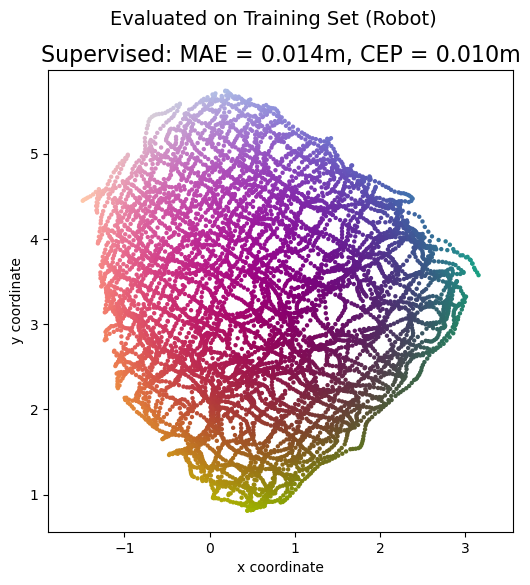

In [12]:
training_set_robot_predictions = supervised_model.predict(training_set_robot_supervised.batch(1024))
errorvectors, errors, mae, cep = CCEvaluation.compute_localization_metrics(training_set_robot_predictions, training_set_robot_groundtruth_positions)
suptitle = f"Evaluated on Training Set (Robot)"
title = f"Supervised: MAE = {mae:.3f}m, CEP = {cep:.3f}m"
CCEvaluation.plot_colorized(training_set_robot_predictions, training_set_robot_groundtruth_positions, suptitle = suptitle, title = title)

### Evaluation on Test Set

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


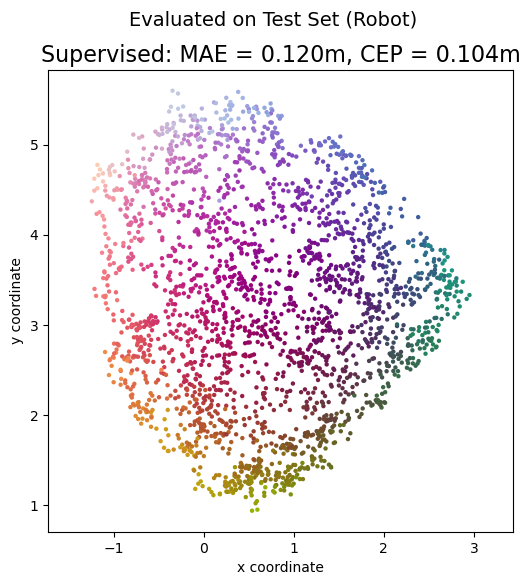

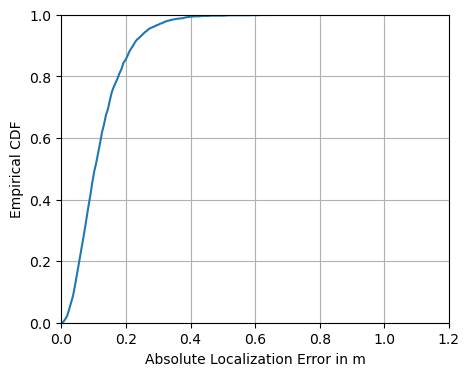

   MAE: 0.120
  DRMS: 0.145
   CEP: 0.104
   R95: 0.268
    KS: 0.067
    CT: 0.996
    TW: 0.996


In [13]:
test_set_robot_predictions = supervised_model.predict(test_set_robot_supervised.batch(1024))
errorvectors, errors, mae, cep = CCEvaluation.compute_localization_metrics(test_set_robot_predictions, test_set_robot_groundtruth_positions)
suptitle = f"Evaluated on Test Set (Robot)"
title = f"Supervised: MAE = {mae:.3f}m, CEP = {cep:.3f}m"
CCEvaluation.plot_colorized(test_set_robot_predictions, test_set_robot_groundtruth_positions, suptitle = suptitle, title = title)
metrics = CCEvaluation.compute_all_performance_metrics(test_set_robot_predictions, test_set_robot_groundtruth_positions)
CCEvaluation.plot_error_ecdf(test_set_robot_predictions, test_set_robot_groundtruth_positions)
for metric_name, metric_value in metrics.items():
    print(f"{metric_name.upper().rjust(6, " ")}: {metric_value:.3f}")

### Evaluation on Human Test Set (Transfer)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


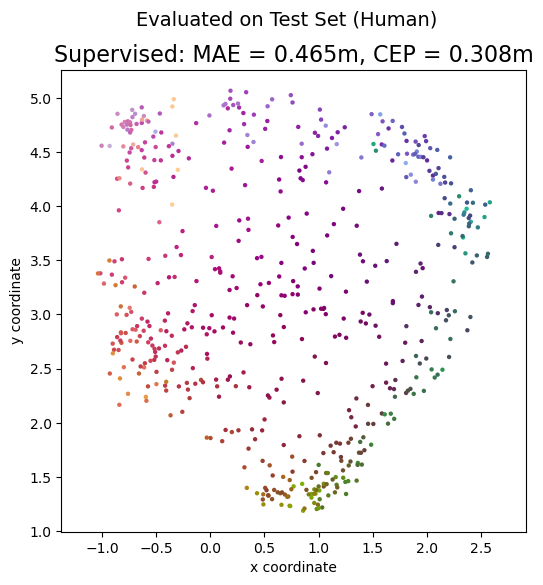

   MAE: 0.465
  DRMS: 0.630
   CEP: 0.308
   R95: 1.352
    KS: 0.206
    CT: 0.966
    TW: 0.978


In [14]:
test_set_human_predictions = supervised_model.predict(test_set_human_supervised.batch(1024))
errorvectors, errors, mae, cep = CCEvaluation.compute_localization_metrics(test_set_human_predictions, test_set_human_groundtruth_positions)
suptitle = f"Evaluated on Test Set (Human)"
title = f"Supervised: MAE = {mae:.3f}m, CEP = {cep:.3f}m"
CCEvaluation.plot_colorized(test_set_human_predictions, test_set_human_groundtruth_positions, suptitle = suptitle, title = title)
metrics = CCEvaluation.compute_all_performance_metrics(test_set_human_predictions, test_set_human_groundtruth_positions)
for metric_name, metric_value in metrics.items():
    print(f"{metric_name.upper().rjust(6, " ")}: {metric_value:.3f}")